# GPU vs CPU - Speed Comparison

In [7]:
import sys,os

# go up a dir
os.chdir(os.path.dirname(os.path.abspath("./")))
print(os.getcwd())



/Users/matthewcox/Documents/UCL/MSc


In [8]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from model.soen_model import SOENModel
from model_config_files.two_moons_config import TwoMoonsConfig
from utils.soen_model_utils import *

In [9]:
def check_model_device(model):
    model_device = model.device
    for name, param in model.named_parameters():
        if param.device != model_device:
            print(f"Warning: Parameter {name} is on {param.device}, not on {model_device}")
    for name, buffer in model.named_buffers():
        if buffer.device != model_device:
            print(f"Warning: Buffer {name} is on {buffer.device}, not on {model_device}")
    print("All model parameters and buffers checked.")



    
config = SOENConfig(
    # Network structure #
    ####################
    num_input=100,
    num_hidden=0,
    num_output=0,
    input_type="flux",
    
    # simulation parameters #
    #########################
    dt=0.01,
    max_iter=10,
    tol=1e-6, 
    run_to_equilibrium=False,
    track_state_evolution = True,
    track_energy = False,
    
    # initialization params #
    #########################
    init_scale=0.1,
    enforce_symmetric_weights=False,
    
    # Dynamics #
    ############
    gamma_mean=1.0,
    gamma_std=0.1,
    tau_mean=1.0,
    tau_std=0.1,
    
    # Constraints
    enforce_non_negativity_in_gamma=True,
    enforce_non_negativity_in_tau=True,
    
    # Connectivity probabilities
    p_input_hidden=1,
    p_hidden_output=1,
    p_input_input=1,
    p_hidden_hidden=1,
    p_output_output=1,
    
    # Feedback and self-connections
    allow_self_connections=False,
    allow_output_to_hidden_feedback=True,
    allow_hidden_to_input_feedback=True,
    allow_skip_connections = True,
    p_skip_connections = 1,  # Probability of skip connections (input to output)

    
    # Noise parameters: this is the standard deviation centered around 0 that gets added to the flux incident to each node
    train_noise_std=0.0,
    test_noise_std=0.0,
    
    # Learning parameters
    learnable_params=["J"],
    
    
    clip_phi=True,
    clip_state = True,
    

    activation_function="gaussian_mixture",



)


In [10]:


def run_tests(config, num_inputs, n_runs, batch_size):
    results = []
    
    for num_input in num_inputs:
        config.num_input = num_input
        
        for device in ["CPU","MPS"]:
            if device == "CPU":
                config.device = torch.device("cpu")
            else:
                config.device = torch.device("mps")
            model = SOENModel(config).to(config.device)
            
            single_input_sample = torch.rand(1, model.num_input).abs()
            input_values = single_input_sample.repeat(batch_size, 1).to(config.device)
            initial_state = torch.rand(batch_size, model.num_input).to(config.device)
            
            run_times = []
            for _ in range(n_runs):
                start_time = time.time()
                model(input_values, initial_state)
                end_time = time.time()
                run_times.append((end_time - start_time) * 1000)  # Convert to milliseconds
            
            results.append({
                "num_input": num_input,
                "device": device,
                "time": np.min(run_times)
            })
        
        print(f"Completed tests for {num_input} nodes")
    
    return pd.DataFrame(results)




num_inputs = [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
n_runs = 3
batch_size = 256





results_df = run_tests(config, num_inputs, n_runs, batch_size)


Completed tests for 10 nodes
Completed tests for 50 nodes
Completed tests for 100 nodes
Completed tests for 200 nodes
Completed tests for 300 nodes
Completed tests for 400 nodes
Completed tests for 500 nodes
Completed tests for 600 nodes
Completed tests for 700 nodes
Completed tests for 800 nodes
Completed tests for 900 nodes
Completed tests for 1000 nodes


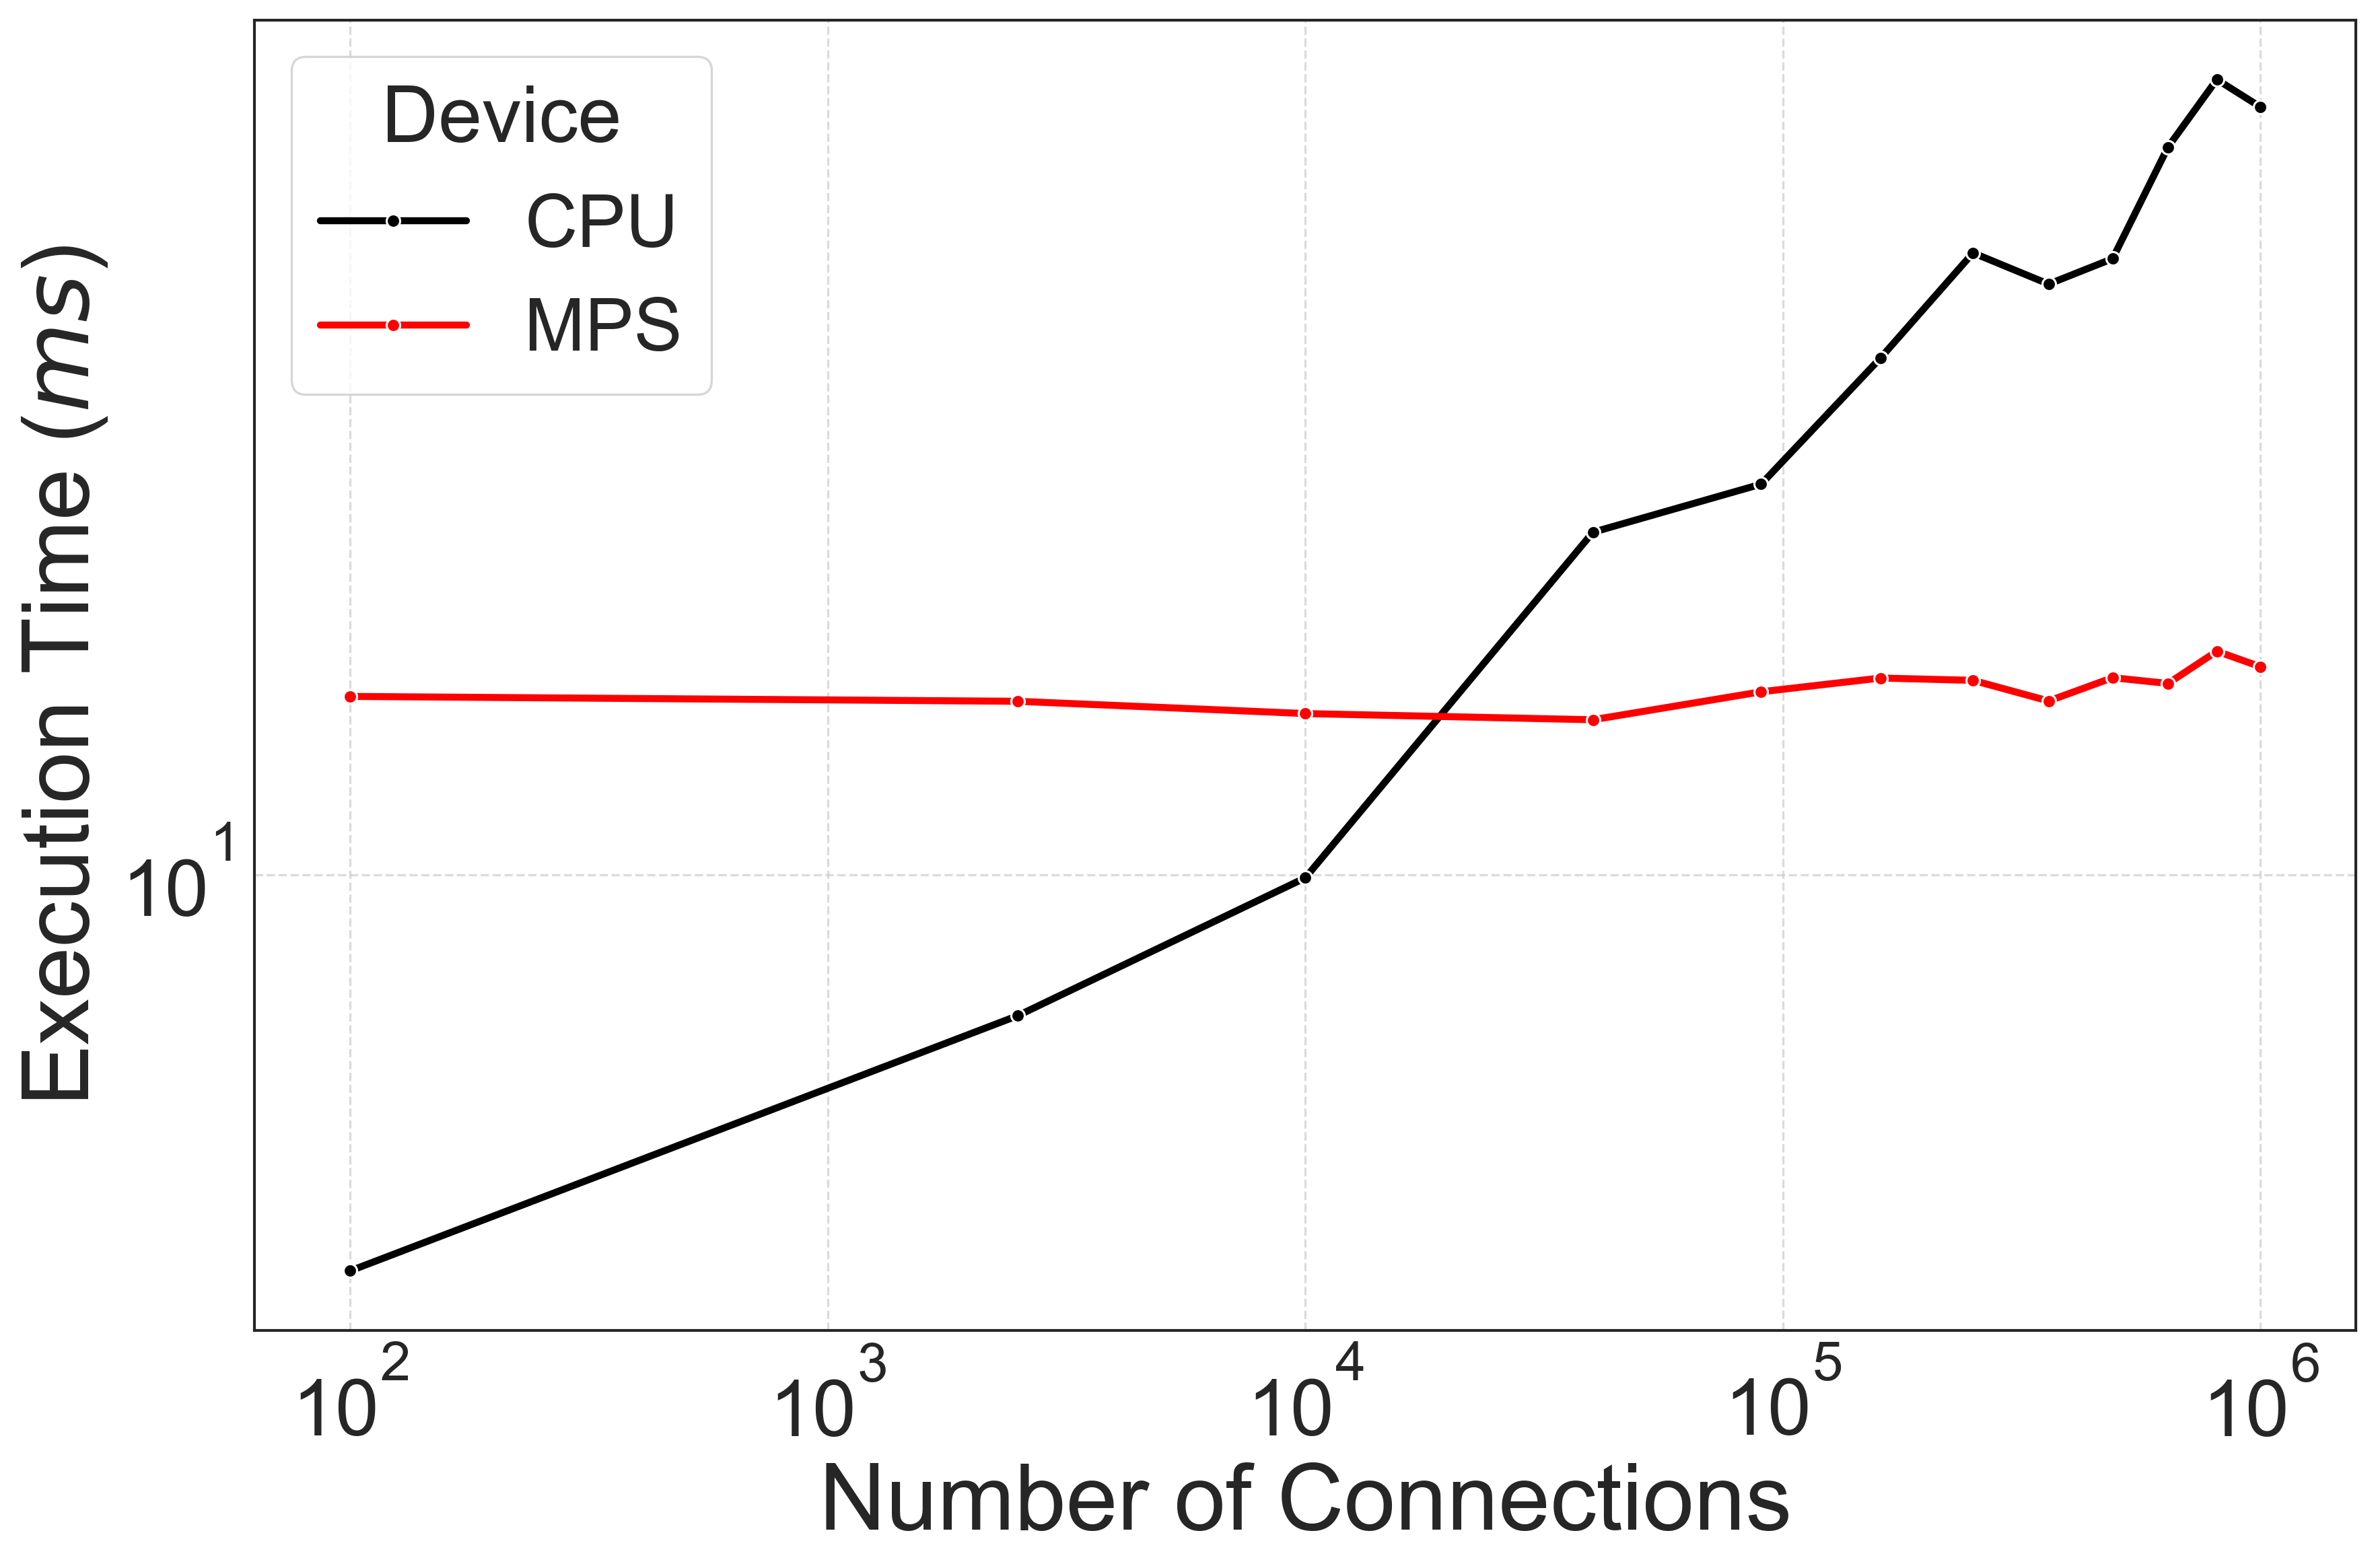

In [11]:

def plot_results(df):
    # Calculate number of connections
    df['num_connections'] = df['num_input'] ** 2
    
    plt.figure(figsize=(12, 8), dpi=300)
    sns.set_style("white")
    sns.set_context("paper", font_scale=1.5)
    
    ax = sns.lineplot(
        data=df, 
        x="num_connections", 
        y="time", 
        hue="device", 
        marker="o", 
        linewidth=2.5, 
        palette={"CPU": "black", "MPS": "red"}
    )
    
    plt.xlabel("Number of Connections", fontsize=33)
    plt.ylabel("Execution Time ($ms$)", fontsize=33)
    plt.legend(title="Device", title_fontsize=28, fontsize=26)
    
    ax.tick_params(axis='both', which='major', labelsize=28)
    
    # Add faint dashed grid lines
    ax.grid(True, linestyle='--', alpha=0.7)

    # Set x-axis to log scale
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # Format x-axis labels
    # ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    plt.tight_layout()
    plt.show()

plot_results(results_df) 

In [ ]:
results_df

,num_input,device,time
0,10,CPU,1.662970
1,10,MPS,15.136003
2,50,CPU,1.755953
3,50,MPS,14.845371
4,100,CPU,2.040148
5,100,MPS,14.955044
6,200,CPU,2.953053
7,200,MPS,14.720917
8,300,CPU,3.309011
9,300,MPS,15.625954
